In [1]:
import numpy as np
from math import exp
import matplotlib.pyplot as plt
from matplotlib import animation
from tqdm.notebook import tnrange

In [2]:
def solve_linear(a, b, c, d):
    nf = len(d)
    ac, bc, cc, dc = map(np.array, (a, b, c, d))
    for it in range(1, nf):
        mc = ac[it - 1] / bc[it - 1]
        bc[it] = bc[it] - mc * cc[it - 1] 
        dc[it] = dc[it] - mc * dc[it - 1]
    xc = bc
    xc[-1] = dc[-1] / bc[-1]
    for il in range(nf - 2, -1, -1):
        xc[il] = (dc[il] - cc[il] * xc[il + 1]) / bc[il]
    return xc

In [3]:
K = 1.6e6
E = 8e4
alpha = 1 # непонятно
Q = 7e5
ro = 830
C = 1990
lambd = 0.13
D = 8e-8
R = 8.31
T0 = 293 # начальная температура
Tm = T0 + Q / C # вроде бы конечная температура
kappa = lambd / (ro * C)
U = (2 * K * lambd / (Q * ro * Q / C) * T0 / Tm * ((R * Tm * Tm / E) ** 2) * exp(-E / (R * Tm))) ** 0.5
beta = R * Tm / E
gamma = R * Tm * Tm / (E * Q / C)
delta_h = kappa / U
delta_r = beta * delta_h
delta_d = D / U
Le = delta_d / delta_h

In [4]:
print(Le)

1.0164307692307692


In [27]:
a = 0
b = 3e-2
dz = 5e-4
z_steps = int((b-a) / dz)

teta = 500
dt = 5e-2
t_steps = int(teta / dt)

r_X = D * dt / (dz ** 2)
r_T = kappa * dt / (dz ** 2)

In [28]:
print(r_X, r_T)

0.016 0.015741357389356423


In [29]:
t_start = np.zeros(z_steps, dtype=np.float64)
x_start = np.zeros(z_steps, dtype=np.float64)

for i in range(1):
    t_start[i] = Tm
    x_start[i] = 0
for i in range(1, z_steps):
    t_start[i] = T0
    x_start[i] = 1

In [30]:
def W(X, T):
    return -K*(X ** alpha)*exp(-E/(R*T)) 

In [31]:
def solve(solver):
    Ts = [t_start]
    Xs = [x_start]
    
    for cur_iter in tnrange(1, t_steps + 1):
        t = dt * cur_iter
        cur_t, cur_x = solver(t, Ts, Xs)
        Ts.append(cur_t)
        Xs.append(cur_x)

    return Ts, Xs

In [32]:
def evident_opposite(t, Ts, Xs):
    next_t_row = np.zeros(z_steps, dtype=np.float64)
    next_x_row = np.zeros(z_steps, dtype=np.float64)

    for i in range(1, z_steps - 1):
        prev_t = Ts[-1][i - 1]
        next_t = Ts[-1][i + 1]
        cur_t = Ts[-1][i]
        
        prev_x = Xs[-1][i - 1]
        next_x = Xs[-1][i + 1]
        cur_x = Xs[-1][i]
        
        next_t_row[i] = cur_t + r_T * (prev_t + next_t - 2 * cur_t) - Q/C * dt * W(cur_x, cur_t)
        next_x_row[i] = cur_x + r_X * (prev_x + next_x - 2 * cur_x) + dt * W(cur_x, cur_t)
    
    next_t_row[0] = Tm
    next_t_row[z_steps - 1] = next_t_row[z_steps - 2]
    
    next_x_row[0] = 0
    next_x_row[z_steps - 1] = next_x_row[z_steps - 2]
    return next_t_row, next_x_row

In [33]:
def non_evident(t, Ts, Xs):
    T_r = dt * kappa / (dz ** 2)
    X_r = dt * D / (dz ** 2)
    prevT = Ts[-1]
    prevX = Xs[-1]
   
    T_a = np.zeros(z_steps - 1, dtype=np.float64)
    T_b = np.zeros(z_steps, dtype=np.float64)
    T_c = np.zeros(z_steps - 1, dtype=np.float64)
    T_d = np.zeros(z_steps, dtype=np.float64)
    
    X_a = np.zeros(z_steps - 1, dtype=np.float64)
    X_b = np.zeros(z_steps, dtype=np.float64)
    X_c = np.zeros(z_steps - 1, dtype=np.float64)
    X_d = np.zeros(z_steps, dtype=np.float64)
    
    T_b[0] = 1
    T_c[0] = 0
    T_d[0] = Tm

    X_b[0] = 1
    X_c[0] = 0
    X_d[0] = 0
    
    for i in range(1, z_steps - 1):
        T_a[i - 1] = T_r
        T_b[i] = -1 - 2 * T_r
        T_c[i] = T_r
        T_d[i] = Q * dt * W(prevX[i], prevT[i]) / C - prevT[i]

        X_a[i - 1] = X_r
        X_b[i] = -1 - 2 * X_r
        X_c[i] = X_r
        X_d[i] = -(prevX[i] + dt * W(prevX[i], prevT[i]))
        
    T_a[z_steps - 2] = 0
    T_b[z_steps - 1] = 1
    T_d[z_steps - 1] = T0
    
    X_a[z_steps - 2] = 0
    X_b[z_steps - 1] = 1
    X_d[z_steps - 1] = 1
        
    newT = solve_linear(T_a, T_b, T_c, T_d)
    newX = solve_linear(X_a, X_b, X_c, X_d)
    return newT, newX

In [34]:
aaa = np.array([1, 2, 3])
bbb = np.insert(aaa, 0, 0)
np.append(bbb, 7)

array([0, 1, 2, 3, 7])

In [35]:
Ts, Xs = solve(non_evident)

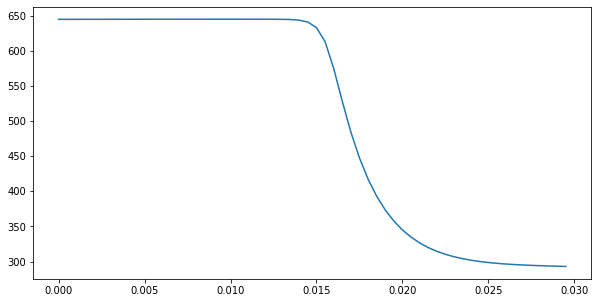

In [38]:
fig, ax = plt.subplots(figsize=(10,5))

x = np.arange(a, b, dz)
line, = ax.plot(x, Ts[0])

def animate(i):
    line.set_ydata(Ts[i])  # update the data
    return line,

# Init only required for blitting to give a clean slate.
def init():
    line.set_ydata(np.ma.array(x, mask=True))
    return line,

ani = animation.FuncAnimation(fig, animate, tnrange(0, t_steps, 50), init, blit=True)
ani.save('./T.gif', writer='pillow', fps=150)

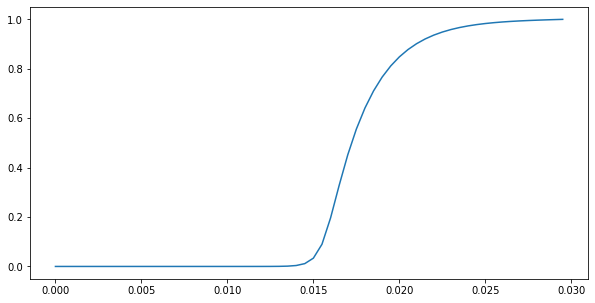

In [39]:
fig, ax = plt.subplots(figsize=(10,5))

x = np.arange(a, b, dz)
line, = ax.plot(x, Xs[0])

def animate(i):
    line.set_ydata(Xs[i])  # update the data
    return line,

# Init only required for blitting to give a clean slate.
def init():
    line.set_ydata(np.ma.array(x, mask=True))
    return line,

ani = animation.FuncAnimation(fig, animate, tnrange(0, t_steps, 50), init, blit=True)
ani.save('./X.gif', writer='pillow', fps=150)